<a href="https://colab.research.google.com/github/dangcaptkd2/PracticeWithTensorFlow/blob/main/Text_classification_with_TF_Hub_Movie_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
Hub version:  0.11.0
GPU is available


# Download the IMDB dataset

In [2]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX033LG/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX033LG/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX033LG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


#Explore data

 Each example is a sentence representing the movie review and a corresponding label. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [6]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
print(train_examples_batch)
print(train_labels_batch)

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

#Build the model

use a pre-trained text embedding model from TensorFlow Hub called "google/nnlm-en-dim50/2".

In [7]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

build the model

In [8]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


 compile the model.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

train the model

In [10]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=30,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/30
30/30 [==============================] - 5s 74ms/step - loss: 0.6818 - accuracy: 0.5075 - val_loss: 0.6221 - val_accuracy: 0.5444
Epoch 2/30
30/30 [==============================] - 2s 69ms/step - loss: 0.5834 - accuracy: 0.6230 - val_loss: 0.5218 - val_accuracy: 0.7453
Epoch 3/30
30/30 [==============================] - 3s 70ms/step - loss: 0.4603 - accuracy: 0.7963 - val_loss: 0.4178 - val_accuracy: 0.8093
Epoch 4/30
30/30 [==============================] - 3s 70ms/step - loss: 0.3322 - accuracy: 0.8673 - val_loss: 0.3553 - val_accuracy: 0.8357
Epoch 5/30
30/30 [==============================] - 3s 71ms/step - loss: 0.2456 - accuracy: 0.9108 - val_loss: 0.3229 - val_accuracy: 0.8565
Epoch 6/30
30/30 [==============================] - 3s 71ms/step - loss: 0.1797 - accuracy: 0.9419 - val_loss: 0.3102 - val_accuracy: 0.8606
Epoch 7/30
30/30 [==============================] - 3s 70ms/step - loss: 0.1349 - accuracy: 0.9613 - val_loss: 0.3049 - val_accuracy: 0.8696
Epoch 8/30
30

In [11]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.5525 - accuracy: 0.8464
loss: 0.553
accuracy: 0.846


In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [14]:
import matplotlib.pyplot as plt

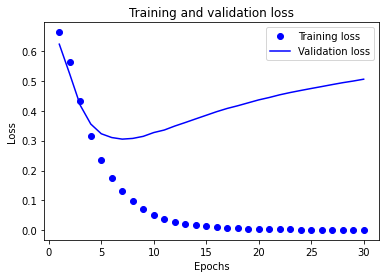

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

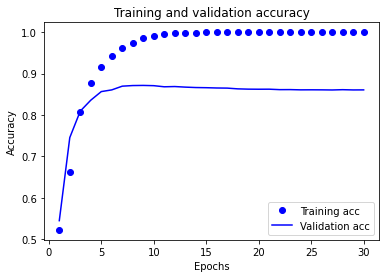

In [16]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()